## Demo of the code used to calculate Elevation and Landcover metric calculations for NABat GRTS cells

by Colin Talbert 2018-11-23

In [1]:
from pathlib import Path

import  pandas as pd
import matplotlib.pyplot as plt
import scipy.ndimage as ndi
import numpy as np

import rasterio
import rasterstats
from owslib.wcs import WebCoverageService

import nabatpy

In [2]:
output_dname = r"Z:\TSH\DD274_NABat\CNHP_data_processing\Derived\2017_output"
out_dir = Path(output_dname)

In [3]:
site_md_fname = r"F:\CO_NABat\CO NABAT 2017 Bulk_Stationary_Acoustic_Template.csv"
site_md = pd.read_csv(site_md_fname, skiprows=[1], index_col=['Grts Id', 'Location Name'])
site_md.head()

UTME     UTMN First Monitoring Night  \
Grts Id Location Name                                           
2       NW             170440  4355996              6/28/2017   
        SW             174304  4354564              6/28/2017   
        NE             176892  4360344              6/28/2017   
        SE             178373  4353544              6/28/2017   
61      NE             548408  4211808              6/21/2017   

                      Fourth Monitoring Night                      Detector  \
Grts Id Location Name                                                         
2       NW                           7/1/2017    WILDLIFE ACOUSTICS SM2Bat+   
        SW                           7/1/2017    WILDLIFE ACOUSTICS SM2Bat+   
        NE                           7/1/2017    WILDLIFE ACOUSTICS SM2Bat+   
        SE                           7/1/2017    WILDLIFE ACOUSTICS SM2Bat+   
61      NE                          6/24/2017  WILDLIFE ACOUSTICS SM2Bat192   

                                      Microphone  Microphone Orientation  \
Grts Id Location Name                                                      
2       NW             Wildlife Acoustics SMX-US                     NaN   
        SW             Wildlife Acoustics SMX-US                     NaN   
        NE             Wildlife Acoustics SMX-US                     NaN   
        SE             Wildlife Acoustics SMX-US                     NaN   
61      NE             Wildlife Acoustics SMX-US                     NaN   

                       Microphone Height (meters)  \
Grts Id Location Name                               
2       NW                                    2.0   
        SW                                    2.0   
        NE                                    2.0   
        SE                                    2.0   
61      NE                                    3.0   

                       Distance to Nearest Clutter (meters) Clutter Type  \
Grts Id Location Name                                                      
2       NW                                              NaN   vegetation   
        SW                                              NaN   vegetation   
        NE                                              NaN   vegetation   
        SE                                              NaN   vegetation   
61      NE                                              NaN   vegetation   

                       Distance to Nearest Water (meters)  Water Type  \
Grts Id Location Name                                                   
2       NW                                            NaN         NaN   
        SW                                            NaN         NaN   
        NE                                            NaN         NaN   
        SE                                            NaN         NaN   
61      NE                                            NaN         NaN   

                       Percent Clutter Broad Habitat Type  \
Grts Id Location Name                                       
2       NW                         NaN          shrubland   
        SW                         NaN          shrubland   
        NE                         NaN          shrubland   
        SE                         NaN          shrubland   
61      NE                         NaN            prairie   

                      Audio Recording Name (*.wav *.zc) Software Type  
Grts Id Location Name                                                  
2       NW                                           FS   Sonobat 4.x  
        SW                                           FS   Sonobat 4.x  
        NE                                           FS   Sonobat 4.x  
        SE                                           FS   Sonobat 4.x  
61      NE                                           FS   Sonobat 4.x

In [4]:
from pyproj import Proj, transform

inProj = Proj(init='epsg:26912')
outProj = Proj(init='epsg:4326')

def from_utm(row):
    x1,y1 = row['UTME'], row['UTMN']
    x2,y2 = transform(inProj,outProj,x1,y1)
    return (x2,y2)

site_md['long'], site_md['lat'] = zip(*site_md.apply(from_utm, axis=1))

In [5]:
import nabatpy
colorado = nabatpy.get_grts_data(grid_frame='Conus', state="Colorado")

In [6]:
sampled_ids = list(site_md.index.get_level_values('Grts Id').unique())
print(sampled_ids)

[2, 61, 82, 157, 221, 253, 306, 317, 338, 381, 509, 562, 573, 701, 786, 829, 957, 989, 1005, 1026, 1085, 1106, 1181, 1277, 1405, 1437, 1469, 1533, 1725, 1853, 2109, 2130, 2205, 2354, 2365, 2461, 2493, 2610, 2621, 2717, 2749, 2781, 2834, 2877, 2941, 3005, 3053, 3069, 3197, 3229]


In [7]:
wcs=WebCoverageService('https://elevation.nationalmap.gov:443/arcgis/services/3DEPElevation/ImageServer/WCSServer', version='1.0.0')

# this is the resolution for 1 arc second (30m DEM)
res = 0.00027777777803598

elev=wcs['DEP3ElevationPrototype']


def get_elev(grts_id):
    output = wcs.getCoverage(identifier='DEP3ElevationPrototype', bbox=tuple(colorado[colorado.GRTS_ID==grts_id]['geometry'].bounds.iloc[0]), format='GeoTIFF', resx=res, resy=res, crs=4326)
    contents = output.read()

    import rasterio
    from rasterio.io import MemoryFile
    elev = MemoryFile(contents).open()
    data = elev.read().squeeze()
    return data


data = get_elev(2)

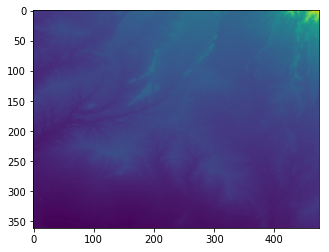

In [8]:
plt.imshow(data)

### The first thing we want is just the min, max, and mean elevation

In [9]:
data.min(), data.max(), data.mean()

(1402.5642, 1900.825, 1496.1832)

### Next we want to calculate some roughness indices (TPI, and TRI)

These are base off descriptions found here: http://gis4geomorphology.com/roughness-topographic-position/

Jenness, 2002

https://download.osgeo.org/qgis/doc/reference-docs/Terrain_Ruggedness_Index.pdf

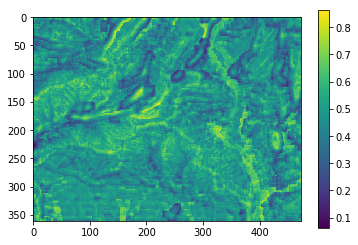

In [10]:
def calc_tpi(data, size=10):
    max_data = ndi.maximum_filter(data, size=size)
    min_data = ndi.minimum_filter(data, size=size)
    mean_data = ndi.uniform_filter(data, size=size)

    tpi = (mean_data-min_data)/(max_data-min_data)
    return tpi
    
    
tpi = calc_tpi(data)
    
plt.imshow(tpi)
plt.colorbar()

C:\Anaconda3\envs\pyviz\lib\site-packages\ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in sqrt
  """


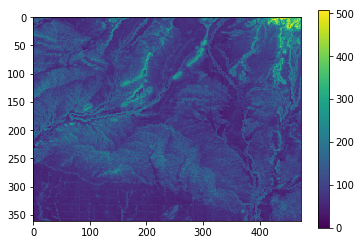

In [11]:
def calc_tri(data, size=3):
    max_data = ndi.maximum_filter(data, size=size)
    min_data = ndi.minimum_filter(data, size=size)

    tri = np.sqrt(np.absolute((np.square(max_data) - np.square(min_data) )))
    return tri

tri = calc_tri(data)
    
plt.imshow(tri)
plt.colorbar()

### Now let's calculate some metrics of landcover

In [12]:
def pcnt_nlcd_water(x):
    return ((x >= 10) & (x < 20)).sum() / x.count() * 100

def pcnt_nlcd_developed(x):
    return ((x >= 20) & (x < 30)).sum() / x.count() * 100

def pcnt_nlcd_barren(x):
    return ((x >= 30) & (x < 40)).sum() / x.count() * 100

def pcnt_nlcd_forest(x):
    return ((x >= 40) & (x < 50)).sum() / x.count() * 100

def pcnt_nlcd_shrubland(x):
    return ((x >= 50) & (x < 60)).sum() / x.count() * 100

def pcnt_nlcd_herbaceous(x):
    return ((x >= 70) & (x < 80)).sum() / x.count() * 100

def pcnt_nlcd_planted(x):
    return ((x >= 80) & (x < 90)).sum() / x.count() * 100

def pcnt_nlcd_wetlands(x):
    return ((x >= 90) & (x < 100)).sum() / x.count() * 100

In [13]:
# this is a local copy of the 2011 nlcd layer available here: https://www.mrlc.gov/nlcd2011.php
nlcd_fname = r"Y:\Veg_LandCover\NLCD\nlcd11\nlcd_2011_landcover.tif"
nlcd = rasterio.open(nlcd_fname)

#we need to project our grts cells to match this projection
colorado_aes = colorado.to_crs(nlcd.crs)

In [14]:
colorado_aes = colorado_aes.set_index('GRTS_ID', drop=False)
this_sample = colorado_aes.loc[sampled_ids]

In [15]:
stats = rasterstats.zonal_stats(this_sample.geometry, nlcd_fname, add_stats={'pcnt_water':pcnt_nlcd_water,
                                                                                                  'pcnt_developed':pcnt_nlcd_developed,
                                                                                                  'pcnt_barren':pcnt_nlcd_barren,
                                                                                                  'pcnt_forest':pcnt_nlcd_forest,
                                                                                                  'pcnt_shrubland':pcnt_nlcd_shrubland,
                                                                                                  'pcnt_herbaceous':pcnt_nlcd_herbaceous,
                                                                                                  'pcnt_planted':pcnt_nlcd_planted,
                                                                                                  'pcnt_wetlands':pcnt_nlcd_wetlands})

In [16]:
stats = pd.DataFrame(stats)

nlcd_stats = stats.iloc[:, 4:]
nlcd_stats.index = this_sample.index
nlcd_stats['GRTS_ID'] = this_sample.index

this_sample = nlcd_stats

nlcd_stats.head()

,pcnt_barren,pcnt_developed,pcnt_forest,pcnt_herbaceous,pcnt_planted,pcnt_shrubland,pcnt_water,pcnt_wetlands,GRTS_ID
GRTS_ID,,,,,,,,,
2,0.101904,0.909919,0.084769,0.149699,7.662618,90.989187,0.034269,0.067635,2
61,0.197495,0.000000,0.000000,93.181470,1.854106,4.482861,0.019840,0.264228,61
82,0.000000,3.577451,0.101002,14.601989,81.667253,0.046894,0.005411,0.000000,82
157,0.430277,0.000000,75.671412,11.782423,2.087741,9.991394,0.036753,0.000000,157
221,0.063645,0.147908,63.556420,0.000000,1.891427,34.172075,0.000000,0.168525,221


###  now add on our elevation stats

In [17]:
def calc_elev_stats(row):
    grts_id = row['GRTS_ID']
    data = get_elev(grts_id)
    
    ned_min, ned_max, ned_mean = data.min(), data.max(), data.mean()
    
    cell_tpi = calc_tpi(data).mean()
    cell_tri = calc_tri(data).mean()

    return (ned_min, ned_max, ned_mean, cell_tpi, cell_tri)

this_sample['ned_min'], this_sample['ned_max'], this_sample['ned_mean'], this_sample['ned_tpi'], this_sample['ned_tri'] = zip(*this_sample.apply(calc_elev_stats, axis=1))

C:\Anaconda3\envs\pyviz\lib\site-packages\ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in sqrt
  """
C:\Anaconda3\envs\pyviz\lib\site-packages\ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in true_divide
  


In [18]:
grtsid = this_sample.pop('GRTS_ID')

In [19]:
this_sample.insert(0, 'GridCellID', grtsid)

In [20]:
this_sample.head()

,GridCellID,pcnt_barren,pcnt_developed,pcnt_forest,pcnt_herbaceous,pcnt_planted,pcnt_shrubland,pcnt_water,pcnt_wetlands,ned_min,ned_max,ned_mean,ned_tpi,ned_tri
GRTS_ID,,,,,,,,,,,,,,
2,2,0.101904,0.909919,0.084769,0.149699,7.662618,90.989187,0.034269,0.067635,1402.564209,1900.824951,1496.183228,0.484234,106.974846
61,61,0.197495,0.000000,0.000000,93.181470,1.854106,4.482861,0.019840,0.264228,1469.240723,1703.574097,1555.764038,0.508898,90.703613
82,82,0.000000,3.577451,0.101002,14.601989,81.667253,0.046894,0.005411,0.000000,0.000000,0.000000,0.000000,NaN,0.000000
157,157,0.430277,0.000000,75.671412,11.782423,2.087741,9.991394,0.036753,0.000000,2124.309082,3038.861084,2498.387207,0.470928,302.863037
221,221,0.063645,0.147908,63.556420,0.000000,1.891427,34.172075,0.000000,0.168525,1558.497192,2035.352783,1830.466431,0.537412,195.073059


In [21]:
this_sample.to_csv(out_dir.joinpath("GrtsCellCovariates.csv"))

PermissionError: [Errno 13] Permission denied: 'Z:\\TSH\\DD274_NABat\\CNHP_data_processing\\Derived\\2017_output\\GrtsCellCovariates.csv'

In [ ]:
import seaborn as sns
sns.set(style="darkgrid")


g = sns.jointplot("pcnt_forest", "ned_mean", data=this_sample, kind="reg",
                  color="m", height=7);